In [169]:
import random, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary

from sklearn.metrics import f1_score

In [56]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(69)

In [57]:
ddos_data = pd.read_csv('/Users/irfanmasudi/DeepLearning/DDoS/APA-DDoS-Dataset.csv')
ddos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151200 entries, 0 to 151199
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip.src           151200 non-null  object
 1   ip.dst           151200 non-null  object
 2   tcp.srcport      151200 non-null  int64 
 3   tcp.dstport      151200 non-null  int64 
 4   ip.proto         151200 non-null  int64 
 5   frame.len        151200 non-null  int64 
 6   tcp.flags.syn    151200 non-null  int64 
 7   tcp.flags.reset  151200 non-null  int64 
 8   tcp.flags.push   151200 non-null  int64 
 9   tcp.flags.ack    151200 non-null  int64 
 10  ip.flags.mf      151200 non-null  int64 
 11  ip.flags.df      151200 non-null  int64 
 12  ip.flags.rb      151200 non-null  int64 
 13  tcp.seq          151200 non-null  int64 
 14  tcp.ack          151200 non-null  int64 
 15  frame.time       151200 non-null  object
 16  Packets          151200 non-null  int64 
 17  Bytes     

In [120]:
filtered_data = ddos_data.drop(columns=ddos_data.columns[ddos_data.nunique() == 1])
filtered_data = filtered_data.drop(columns=['ip.src', 'frame.time'], axis=1)
filtered_data.head()

,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,Label
0,2412,54,1,0,8,432,4,216,4,216,DDoS-PSH-ACK
1,2413,54,1,0,10,540,5,270,5,270,DDoS-PSH-ACK
2,2414,54,1,0,12,648,6,324,6,324,DDoS-PSH-ACK
3,2415,54,1,0,10,540,5,270,5,270,DDoS-PSH-ACK
4,2416,54,1,0,6,324,3,162,3,162,DDoS-PSH-ACK


In [121]:
filtered_data['Label'].value_counts()

Label
Benign          75600
DDoS-PSH-ACK    37800
DDoS-ACK        37800
Name: count, dtype: int64

In [122]:
label_mapping = {'Benign': 0, 'DDoS-PSH-ACK': 1, 'DDoS-ACK': 2} 

In [123]:
filtered_data['Label'] = filtered_data['Label'].map(label_mapping)
filtered_data['Label'].value_counts()

Label
0    75600
1    37800
2    37800
Name: count, dtype: int64

In [124]:
X = filtered_data.drop('Label', axis=1)
X.describe()

,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes
count,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000
mean,27376.943247,99.025126,0.500000,0.500000,9.082665,799.422937,5.048776,390.683981,4.033889,408.738955
std,19634.879546,71.226673,0.500002,0.500002,2.129620,373.759057,1.353814,177.223153,0.963107,197.105807
min,1302.000000,54.000000,0.000000,0.000000,1.000000,54.000000,1.000000,54.000000,0.000000,0.000000
25%,8621.000000,54.000000,0.000000,0.000000,8.000000,432.000000,4.000000,216.000000,4.000000,216.000000
50%,26263.000000,60.000000,0.500000,0.500000,10.000000,1101.500000,6.000000,550.000000,4.000000,551.500000
75%,45566.000000,105.000000,1.000000,1.000000,10.000000,1146.000000,6.000000,560.000000,4.000000,586.000000
max,60998.000000,223.000000,1.000000,1.000000,20.000000,1229.000000,10.000000,561.000000,10.000000,668.000000


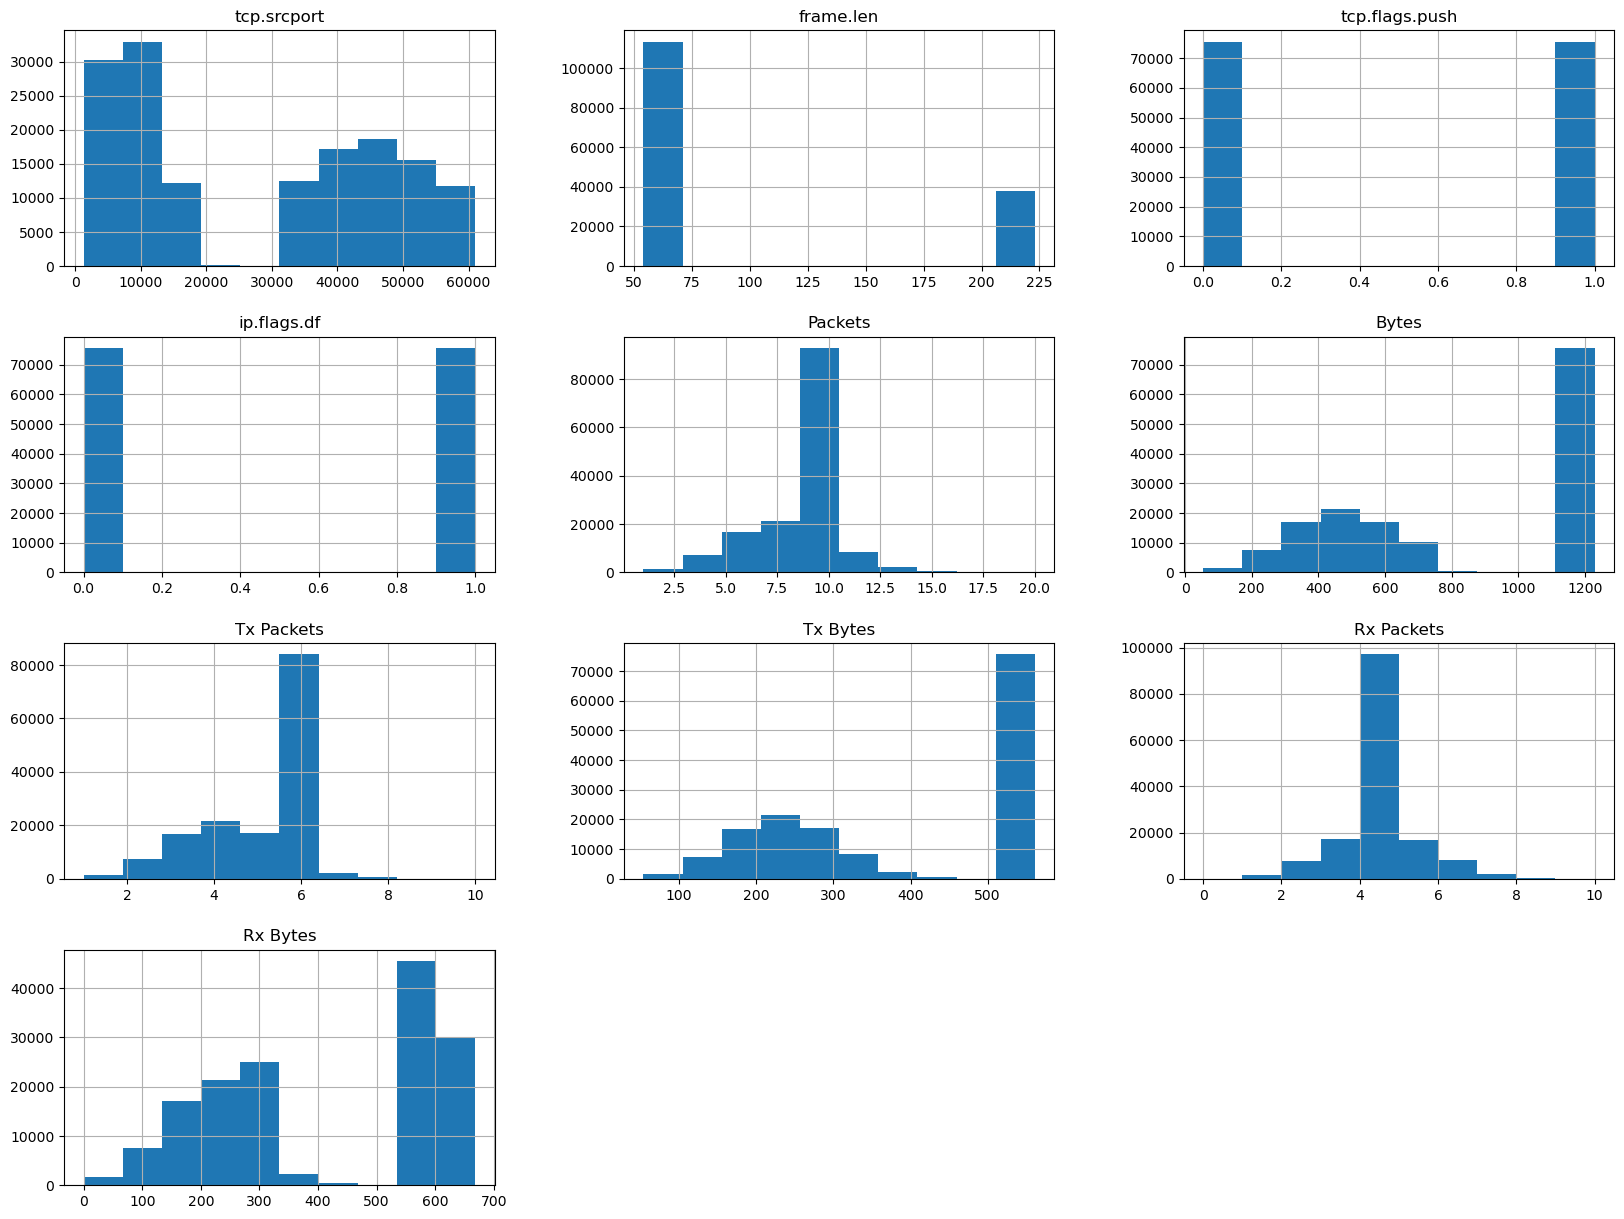

In [125]:
X.hist(bins =10, figsize=(20, 15))
plt.show()

In [126]:
X.isnull().sum()

tcp.srcport       0
frame.len         0
tcp.flags.push    0
ip.flags.df       0
Packets           0
Bytes             0
Tx Packets        0
Tx Bytes          0
Rx Packets        0
Rx Bytes          0
dtype: int64

In [127]:
X = X.to_numpy()
y = filtered_data['Label'].to_numpy()

print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

X.shape (151200, 10) X.dtype int64
y.shape (151200,) y.dtype int64


In [199]:
# standarization
standarization = StandardScaler()
X_standared = standarization.fit_transform(X)
X_standared[:5]

array([[ 0.48921351,  1.52477025,  0.81649658,  1.        ,  0.74278135,
         1.0298991 ,  0.87447463,  0.97925833,  0.38411063,  1.07591265],
       [-1.339216  , -0.69885303,  0.81649658, -1.        , -0.18569536,
        -0.81805993, -0.47087096, -0.81067188,  0.38411063, -0.82417512],
       [ 1.00705236, -0.5400228 , -1.22474487,  1.        ,  0.74278135,
         1.02489113,  0.87447463,  0.97925833,  0.38411063,  1.06626755],
       [ 1.91675978,  1.52477025,  0.81649658,  1.        ,  0.74278135,
         0.9122107 ,  0.87447463,  0.97925833,  0.38411063,  0.84925241],
       [-0.90279833, -0.69885303,  0.81649658, -1.        , -1.11417198,
        -1.08849292, -1.1435437 , -1.09164932, -0.89625809, -1.08459322]])

In [129]:
X_train, X_temp, y_train, y_temp = train_test_split(X_standared, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp)

In [130]:
# check stratified
values, counts = np.unique(y_train, return_counts=True)
print(values, counts)

[0 1 2] [52920 26460 26460]


In [131]:
class myDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [147]:
train_dataset = myDataset(X_train, y_train)
valid_dataset = myDataset(X_val, y_val)
test_dataset = myDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [148]:
for X, y in train_loader:
    print(X)
    print(y)
    break

tensor([[ 0.3474,  1.7265,  1.0000,  1.0000,  0.4308,  0.9915,  0.7026,  0.9554,
         -0.0352,  1.0211],
        [-1.2538, -0.6321,  1.0000, -1.0000, -0.5084, -0.9831, -0.7747, -0.9857,
         -0.0352, -0.9778],
        [ 0.8009, -0.4637, -1.0000,  1.0000,  0.4308,  0.9861,  0.7026,  0.9554,
         -0.0352,  1.0109],
        [ 1.5975,  1.7265,  1.0000,  1.0000,  0.4308,  0.8657,  0.7026,  0.9554,
         -0.0352,  0.7826],
        [-0.8716, -0.6321,  1.0000, -1.0000, -1.4475, -1.2720, -1.5133, -1.2904,
         -1.0735, -1.2518],
        [ 0.4118,  1.7265,  1.0000,  1.0000,  0.4308,  0.9219,  0.7026,  0.9554,
         -0.0352,  0.8892],
        [-0.7816, -0.6321,  1.0000, -1.0000, -2.3867, -1.5610, -2.2520, -1.5951,
         -2.1118, -1.5258],
        [-0.7825, -0.6321, -1.0000, -1.0000,  0.4308, -0.6941, -0.0360, -0.6810,
          1.0031, -0.7039],
        [ 0.4341, -0.4637, -1.0000,  1.0000,  0.4308,  0.9273,  0.7026,  0.9554,
         -0.0352,  0.8993],
        [-0.7123, -

In [149]:
inputs, outputs = train_dataset[0]
print(inputs)
print(outputs)

tensor([ 1.3641, -0.4637, -1.0000,  1.0000,  0.4308,  0.9407,  0.7026,  0.9554,
        -0.0352,  0.9247])
tensor(0)


In [109]:
# Model
class FFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [135]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=3):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

In [136]:
X_train.shape

(105840, 10)

In [186]:
del model

In [187]:
input_size = X_train.shape[1]
num_classes = 3
hidden_size = 32
model = FFNN(input_size, hidden_size, num_classes)

In [188]:
summary(model, input_size=(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             352
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 3]              99
           Softmax-6                    [-1, 3]               0
Total params: 1,507
Trainable params: 1,507
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [190]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [176]:
from torch.utils.tensorboard import SummaryWriter
import datetime

In [191]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [192]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'runs/FFNN_{current_time}'
writer = SummaryWriter(log_dir)

early_stopping = EarlyStopping(patience=5, verbose=True)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_labels = []
    all_predictions = []
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / len(train_loader)
    train_accuracy = 100 * np.mean(np.array(all_labels) == np.array(all_predictions))
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Log training metrics
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('F1 Score/Train', train_f1, epoch)
    
    # Validation step
    model.eval()
    val_loss = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_labels) == np.array(all_predictions))
        val_f1 = f1_score(all_labels, all_predictions, average='weighted')
        
        # Log validation metrics
        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
        writer.add_scalar('F1 Score/Validation', val_f1, epoch)
    
    # Log learning rate
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)
    
    # if epoch % 10 == 0:
    print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, '
            f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}, LR: {current_lr:.6f}')
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if scheduler:
        scheduler.step()

model.load_state_dict(torch.load('checkpoint.pt'))

writer.close()

Epoch [0/100], Train Loss: 0.8725, Train Acc: 84.10%, Train F1: 0.8330, Val Loss: 0.7093, Val Acc: 99.43%, Val F1: 0.9943, LR: 0.000100
Validation loss decreased (inf --> 0.709320). Saving model ...
Epoch [1/100], Train Loss: 0.6100, Train Acc: 99.98%, Train F1: 0.9998, Val Loss: 0.5636, Val Acc: 100.00%, Val F1: 1.0000, LR: 0.000100
Validation loss decreased (0.709320 --> 0.563636). Saving model ...
Epoch [2/100], Train Loss: 0.5582, Train Acc: 100.00%, Train F1: 1.0000, Val Loss: 0.5553, Val Acc: 100.00%, Val F1: 1.0000, LR: 0.000100
Validation loss decreased (0.563636 --> 0.555340). Saving model ...
Epoch [3/100], Train Loss: 0.5543, Train Acc: 100.00%, Train F1: 1.0000, Val Loss: 0.5536, Val Acc: 100.00%, Val F1: 1.0000, LR: 0.000100
Validation loss decreased (0.555340 --> 0.553572). Saving model ...
Epoch [4/100], Train Loss: 0.5532, Train Acc: 100.00%, Train F1: 1.0000, Val Loss: 0.5529, Val Acc: 100.00%, Val F1: 1.0000, LR: 0.000100
Validation loss decreased (0.553572 --> 0.5528

In [193]:
from sklearn.metrics import confusion_matrix, classification_report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6804
           1       1.00      1.00      1.00      3402
           2       1.00      1.00      1.00      3402

    accuracy                           1.00     13608
   macro avg       1.00      1.00      1.00     13608
weighted avg       1.00      1.00      1.00     13608



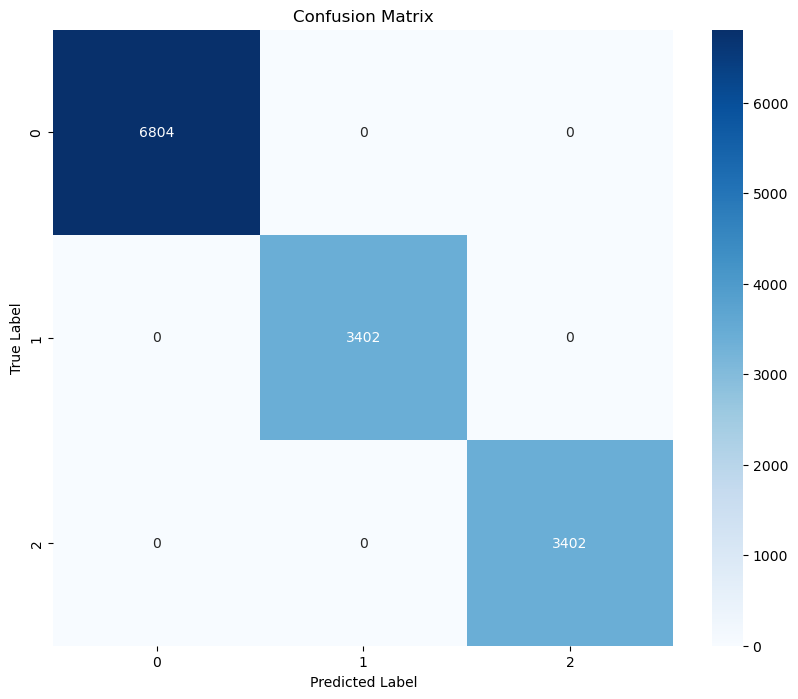

In [194]:
def test_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

y_pred, y_true = test_model(model, test_loader)

# Calculate and print the classification report
print(classification_report(y_true, y_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# If you're using TensorBoard, you can also add the confusion matrix as a figure
writer.add_figure('Confusion Matrix', plt.gcf())

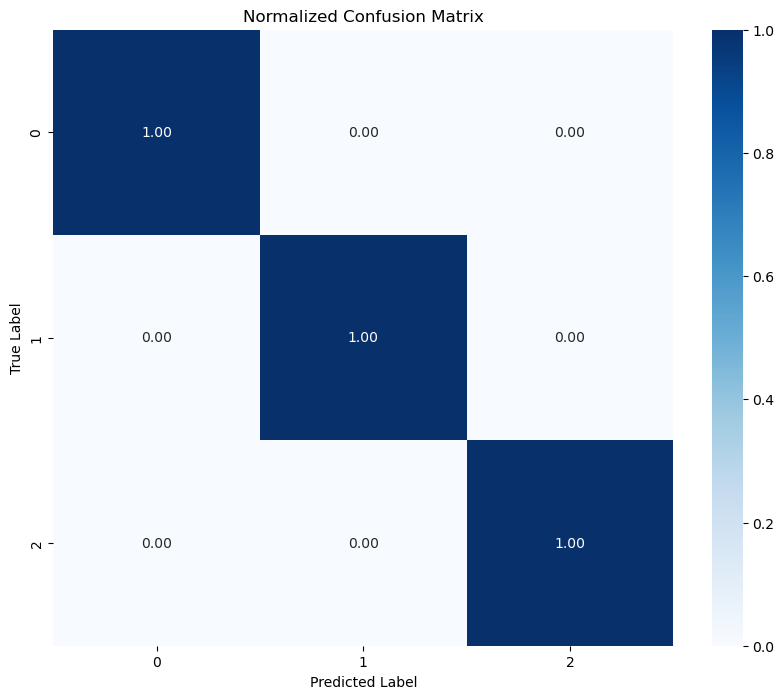

In [198]:
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [197]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

for i in range(len(precision)):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

Class 0:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class 1:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class 2:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

